In [1]:
import copy
import csv
import os
import re
import warnings
import random as python_random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


2025-07-11 16:45:57.831982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752245157.977896  338398 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752245158.041058  338398 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-11 16:45:58.358899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
admissions = pd.read_csv("hosp/admissions.csv")
patients = pd.read_csv("hosp/patients.csv")
diagnoses = pd.read_csv("hosp/diagnoses_icd.csv")
icustays = pd.read_csv("icu/icustays.csv")
#chartevents = pd.read_csv("icu/chartevents.csv", chunksize=250000)  # Adjusted chunk size
labevents = pd.read_csv("hosp/labevents.csv")
#discharge = pd.read_csv("discharge.csv")


In [3]:
#discharge = pd.read_csv("discharge.csv")
LVEF = discharge[discharge['text'].str.contains(r'LVEF')]
print(LVEF)

               note_id  subject_id   hadm_id note_type  note_seq  \
9       10000764-DS-11    10000764  27897940        DS        11   
10      10000826-DS-17    10000826  20032235        DS        17   
18      10000980-DS-20    10000980  29654838        DS        20   
19      10000980-DS-21    10000980  26913865        DS        21   
24      10000980-DS-26    10000980  20897796        DS        26   
...                ...         ...       ...       ...       ...   
331782  19999784-DS-22    19999784  29889147        DS        22   
331783  19999784-DS-23    19999784  29956342        DS        23   
331784  19999784-DS-24    19999784  24755486        DS        24   
331790  19999840-DS-20    19999840  26071774        DS        20   
331792   19999987-DS-2    19999987  23865745        DS         2   

                  charttime            storetime  \
9       2132-10-19 00:00:00  2132-10-19 18:50:00   
10      2146-12-12 00:00:00  2146-12-12 18:22:00   
18      2188-01-05 00:00:00

In [4]:
LVEF_per = LVEF.copy()
LVEF_per['text'] = LVEF_per['text'].str.extract(r'(normal LVEF|preserved LVEF|LVEF.{0,10}%|LVEF.{0,10}?\d+)', flags=re.IGNORECASE | re.DOTALL)

In [5]:
LVEF_gt = LVEF_per.copy()
LVEF_gt['text'] = LVEF_gt['text'].str.extract(r'LVEF\s*>\s*([0-9]+)', flags=re.IGNORECASE | re.DOTALL)
LVEF_gt = LVEF_gt.dropna(subset=['text'])
#print(LVEF_gt)
#print(LVEF_gt['text'].unique())
#LVEF_gt['text'] = LVEF_gt['text'].str.extract(r'([0-9]+)')
print(LVEF_gt['text'].unique())
#gt_values = LVEF_gt.text.value_counts()
#print(LVEF_gt['text'],gt_values)
gt_values = LVEF_gt['text'].value_counts()
print(LVEF_gt['text'])
print(gt_values)

['55' '65' '75' '50' '60' '45' '70' '43' '40' '64' '47' '30' '71' '58']
10        55
18        55
36        55
45        55
52        55
          ..
331781    55
331782    55
331783    55
331784    55
331790    55
Name: text, Length: 20404, dtype: object
text
55    19417
60      363
75      220
65      199
70      122
50       63
40        8
45        5
47        2
43        1
64        1
30        1
71        1
58        1
Name: count, dtype: int64


In [6]:
LVEF_lt = LVEF_per.copy()
LVEF_lt['text'] = LVEF_lt['text'].str.extract(r'LVEF\s*<\s*([0-9]+)', flags=re.IGNORECASE | re.DOTALL)
LVEF_lt = LVEF_lt.dropna(subset=['text'])
#LVEF_lt['text'] = LVEF_lt['text'].str.extract(r'(<[<]*[ ]*[0-9]*)', flags=re.IGNORECASE)
#LVEF_lt = LVEF_lt.dropna(subset=['text'])
#print(LVEF_lt)
#LVEF_lt['text'] = LVEF_lt['text'].str.extract(r'([0-9]+)')
print(LVEF_lt['text'].unique())
lt_values = LVEF_lt.text.value_counts()
print(lt_values)

['35' '20' '40' '30' '10' '15' '25' '50' '45']
text
20    124
30     23
40      9
15      7
25      7
10      5
35      3
50      1
45      1
Name: count, dtype: int64


In [7]:
LVEF_et = LVEF_per.copy()
#LVEF_et['text'] = LVEF_et['text'].str.extract(r'(=.*[0-9])')
#LVEF_et = LVEF_et.dropna(subset=['text'])
#print(LVEF_et)
#print(LVEF_et['text'].unique())
#LVEF_et['text'] = LVEF_et['text'].str.extract(r'([0-9]+)')
#print(LVEF_et['text'].unique())
LVEF_et['text'] = LVEF_et['text'].str.extract(r'LVEF\s*=\s*([0-9]+)', flags=re.IGNORECASE | re.DOTALL)
LVEF_et = LVEF_et.dropna(subset=['text'])
LVEF_et['text'] = pd.to_numeric(LVEF_et['text'], errors='coerce')
LVEF_et = LVEF_et[(LVEF_et['text'] >= 0) & (LVEF_et['text'] <= 100)]
et_values = LVEF_et.text.value_counts()
print(LVEF_et, et_values)

               note_id  subject_id   hadm_id note_type  note_seq  \
9       10000764-DS-11    10000764  27897940        DS        11   
19      10000980-DS-21    10000980  26913865        DS        21   
163     10004235-DS-21    10004235  24181354        DS        21   
176     10004401-DS-27    10004401  29988601        DS        27   
195     10004720-DS-11    10004720  22081550        DS        11   
...                ...         ...       ...       ...       ...   
331566   19992938-DS-7    19992938  22834610        DS         7   
331570  19993089-DS-17    19993089  20556903        DS        17   
331599   19993951-DS-9    19993951  29858732        DS         9   
331653  19995780-DS-16    19995780  21942461        DS        16   
331695  19997473-DS-21    19997473  27787494        DS        21   

                  charttime            storetime  text  
9       2132-10-19 00:00:00  2132-10-19 18:50:00    55  
19      2189-07-03 00:00:00  2189-07-03 19:50:00    35  
163     2196

In [8]:
LVEF_text = LVEF_per.copy()
LVEF_text['text'] = LVEF_text['text'].str.extract(r'(normal LVEF|preserved LVEF)', flags=re.IGNORECASE|re.DOTALL)
LVEF_text = LVEF_text.dropna(subset=['text'])
print(LVEF_text['text'].unique())
LVEF_text['text'] = 60
text_values = LVEF_text.text.value_counts()
print(text_values)

['normal LVEF' 'Preserved LVEF' 'preserved LVEF' 'Normal LVEF'
 'preserved lvef' 'NORMAL LVEF']
text
60    2031
Name: count, dtype: int64


In [9]:
print(gt_values, lt_values, et_values)
under_40 = sum([
    (LVEF_et['text'].astype(float) < 40).sum(),
    (LVEF_gt['text'].astype(float) < 40).sum(),
    (LVEF_lt['text'].astype(float) < 40).sum(),
    (LVEF_text['text'].astype(float) <40).sum()
])

between_40_50 = sum([
    ((LVEF_et['text'].astype(float) >= 40) & (LVEF_et['text'].astype(float) < 50)).sum(),
    ((LVEF_gt['text'].astype(float) >= 40) & (LVEF_gt['text'].astype(float) < 50)).sum(),
    ((LVEF_lt['text'].astype(float) >= 40) & (LVEF_lt['text'].astype(float) < 50)).sum(),
    ((LVEF_text['text'].astype(float) >= 40) & (LVEF_text['text'].astype(float) < 50)).sum()
])

over_50 = sum([
    (LVEF_et['text'].astype(float) >= 50).sum(),
    (LVEF_gt['text'].astype(float) >= 50).sum(),
    (LVEF_lt['text'].astype(float) >= 50).sum(),
    (LVEF_text['text'].astype(float) >= 50).sum()
])

print(f"Count under 40: {under_40}")
print(f"Count between 40 and 50: {between_40_50}")
print(f"Count over 50: {over_50}")

text
55    19417
60      363
75      220
65      199
70      122
50       63
40        8
45        5
47        2
43        1
64        1
30        1
71        1
58        1
Name: count, dtype: int64 text
20    124
30     23
40      9
15      7
25      7
10      5
35      3
50      1
45      1
Name: count, dtype: int64 text
40    1497
45    1448
35    1076
50     767
65     636
      ... 
82       2
83       1
0        1
85       1
5        1
Name: count, Length: 77, dtype: int64
Count under 40: 3399
Count between 40 and 50: 3179
Count over 50: 26387


In [10]:
LVEF_all = pd.concat([pd.concat([pd.concat([LVEF_et, LVEF_gt], ignore_index=True),LVEF_lt], ignore_index=True),LVEF_text], ignore_index=True)
print(LVEF_all)
LVEF_over_50 = LVEF_all[LVEF_all['text'].astype(float) >= 50]
print(LVEF_over_50, len(LVEF_over_50))

              note_id  subject_id   hadm_id note_type  note_seq  \
0      10000764-DS-11    10000764  27897940        DS        11   
1      10000980-DS-21    10000980  26913865        DS        21   
2      10004235-DS-21    10004235  24181354        DS        21   
3      10004401-DS-27    10004401  29988601        DS        27   
4      10004720-DS-11    10004720  22081550        DS        11   
...               ...         ...       ...       ...       ...   
32960  19955966-DS-12    19955966  22895257        DS        12   
32961  19975044-DS-15    19975044  20044208        DS        15   
32962  19975740-DS-11    19975740  29321695        DS        11   
32963  19978119-DS-13    19978119  21747256        DS        13   
32964  19998330-DS-16    19998330  27282608        DS        16   

                 charttime            storetime text  
0      2132-10-19 00:00:00  2132-10-19 18:50:00   55  
1      2189-07-03 00:00:00  2189-07-03 19:50:00   35  
2      2196-03-04 00:00:00  21

In [11]:
LVEF_over_50 = LVEF_over_50.drop(['note_type', 'note_seq'], axis=1)
print(LVEF_over_50)

              note_id  subject_id   hadm_id            charttime  \
0      10000764-DS-11    10000764  27897940  2132-10-19 00:00:00   
4      10004720-DS-11    10004720  22081550  2186-11-17 00:00:00   
6      10005817-DS-12    10005817  28661809  2135-01-19 00:00:00   
9      10011189-DS-13    10011189  23456305  2188-03-25 00:00:00   
10     10013643-DS-22    10013643  20023045  2200-10-28 00:00:00   
...               ...         ...       ...                  ...   
32960  19955966-DS-12    19955966  22895257  2147-09-03 00:00:00   
32961  19975044-DS-15    19975044  20044208  2155-03-05 00:00:00   
32962  19975740-DS-11    19975740  29321695  2137-05-05 00:00:00   
32963  19978119-DS-13    19978119  21747256  2188-04-23 00:00:00   
32964  19998330-DS-16    19998330  27282608  2177-07-26 00:00:00   

                 storetime text  
0      2132-10-19 18:50:00   55  
4      2186-11-18 20:37:00   64  
6      2135-01-20 07:43:00   65  
9      2188-03-25 17:56:00   59  
10     2200-1

In [12]:
LVEF_over_50 = LVEF_over_50.rename(columns={"text": "LVEF"})
#print(LVEF_over_50)

In [13]:
LVEF_over_50.to_csv("LVEF.csv", index=False)

In [14]:
# Filter diagnoses for relevant ICD codes
heart_failure_patients = diagnoses[diagnoses["icd_code"].isin(['I5030', '42830', 'I5031', '42831', 'I5032', '42832', 'I5033', '42833'])]
# Merge with LVEF
LVEF_patients = heart_failure_patients.merge(LVEF_over_50, on=["subject_id", "hadm_id"], how="inner")
hf_icu = LVEF_patients.merge(icustays, on=["subject_id", "hadm_id"], how="inner")
#print(hf_icu)
icu_ids = hf_icu["stay_id"].unique()
#print(hf_icu, len(icu_ids))

In [15]:
# Define ITEMIDs for relevant vitals (e.g., Heart Rate, BP, SpO2)
# Define ITEMIDs for vitals and labs
itemid_map = {
    "Heart Rate": 220045,
    "Systolic BP": 220179,
    "Diastolic BP": 220180,
    "SpO2": 220277,
    "Temperature": 223761,
    "BMI": 226512,
    "Bicarbonate": 227443,
    "Creatinine": 220615,
    "Hemoglobin": 220228,
    "INR(PT)": 220562,
    "Platelet Count": 227457,
    "Potassium": 220640,
    "WBC Count": 220546,
    "Sodium": 220645,
    "NT-proBNP": 227444,
    "Troponin T": 227429
}

# Check unique values for 'stay_id' and 'itemid' in a sample chunk
vitals_list = []
print("Unique IDs:", icu_ids)
print(f"Number of unique ICU IDs: {len(icu_ids)}")

# Define chunk size
usecols = ["stay_id", "subject_id", "hadm_id", "charttime", "itemid", "valuenum"]
chunk_size = 5000  # Reduce if memory issues persist
filtered_rows = []

# Process the file in smaller chunks
with pd.read_csv("icu/chartevents.csv", usecols=usecols, chunksize=chunk_size) as reader:
    for chunk in reader:
        chunk["charttime"] = pd.to_datetime(chunk["charttime"])  # Convert datetime in chunks
        chunk_filtered = chunk[
            chunk["stay_id"].isin(icu_ids) & chunk["itemid"].isin(itemid_map.values())
        ]
        if not chunk_filtered.empty:
            filtered_rows.append(chunk_filtered)

# Concatenate filtered chunks if any data exists
if filtered_rows:
    vitals = pd.concat(filtered_rows, ignore_index=True)
    vitals.to_csv("filtered_vitals.csv", index=False)
    print(f"Filtered data saved with {len(vitals)} rows.")
else:
    print("No matching data found.")

'''
# Load relevant data
chunk_size = 1000  # Adjust the chunk size based on your available memory
vitals_list = []
for chunk in pd.read_csv("icu/chartevents.csv", chunksize=chunk_size):
    #chunk_filtered = chunk[(chunk["stay_id"].isin(icu_ids)) & (chunk["itemid"].isin(itemid_map.values()))]
    #vitals_list.append(chunk_filtered)
    #print(vitals_list)
    print(chunk)

# Concatenate all filtered chunks
vitals = pd.concat(vitals_list, ignore_index=True)
print(vitals)  # Check if the vitals dataframe is populated
'''

Unique IDs: [39060235 31532954 33072499 ... 38134381 31144045 36794489]
Number of unique ICU IDs: 2432


/tmp/ipykernel_311450/3099937196.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk["charttime"] = pd.to_datetime(chunk["charttime"])  # Convert datetime in chunks
/tmp/ipykernel_311450/3099937196.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk["charttime"] = pd.to_datetime(chunk["charttime"])  # Convert datetime in chunks
/tmp/ipykernel_311450/3099937196.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk["charttime"] = pd.to_datetime(chunk["charttime"])  # Convert datetime in chunks
/tmp/ipykernel_311450/3099937196.py:35: UserWarning: Could not i

Filtered data saved with 986107 rows.


'\n# Load relevant data\nchunk_size = 1000  # Adjust the chunk size based on your available memory\nvitals_list = []\nfor chunk in pd.read_csv("icu/chartevents.csv", chunksize=chunk_size):\n    #chunk_filtered = chunk[(chunk["stay_id"].isin(icu_ids)) & (chunk["itemid"].isin(itemid_map.values()))]\n    #vitals_list.append(chunk_filtered)\n    #print(vitals_list)\n    print(chunk)\n\n# Concatenate all filtered chunks\nvitals = pd.concat(vitals_list, ignore_index=True)\nprint(vitals)  # Check if the vitals dataframe is populated\n'

In [16]:
vitals = pd.read_csv('filtered_vitals.csv')  
itemid_map = {
    "Heart Rate": 220045,
    "Systolic BP": 220179,
    "Diastolic BP": 220180,
    "SpO2": 220277,
    "Temperature": 223761,
    "BMI": 226512,
    "Bicarbonate": 227443,
    "Creatinine": 220615,
    "Hemoglobin": 220228,
    "INR(PT)": 220562,
    "Platelet Count": 227457,
    "Potassium": 220640,
    "WBC Count": 220546,
    "Sodium": 220645,
    "NT-proBNP": 227444,
    "Troponin T": 227429
}

# Reverse map itemid to readable feature name
itemid_reverse_map = {v: k for k, v in itemid_map.items()}
vitals['feature'] = vitals['itemid'].map(itemid_reverse_map)

#patient_counts = vitals.groupby('feature')['subject_id'].nunique().sort_values(ascending=False)
#pd.set_option('display.max_rows', 15)
#print(patient_counts)


In [25]:
# Add death labels
admissions["admittime"] = pd.to_datetime(admissions["admittime"])
admissions["dischtime"] = pd.to_datetime(admissions["dischtime"])
admissions["deathtime"] = pd.to_datetime(admissions["deathtime"])

# Calculate death flags
admissions["death_within_30_days"] = (
    (admissions["deathtime"] - admissions["admittime"]).dt.days <= 30
) & admissions["deathtime"].notnull()

admissions["death_within_1_year"] = (
    (admissions["deathtime"] - admissions["admittime"]).dt.days <= 365
) & admissions["deathtime"].notnull()

# Calculate age
patients["anchor_year"] = pd.to_numeric(patients["anchor_year"], errors="coerce")
patients["anchor_age"] = pd.to_numeric(patients["anchor_age"], errors="coerce")
patients["age_admission"] = patients["anchor_age"]  # or join using admittime year if needed

# Merge patient demographics with ICU data
demo = admissions.merge(patients[["subject_id", "gender", "anchor_age"]], on="subject_id", how="left")
#demo = demo[["subject_id", "hadm_id", "death_within_30_days", "death_within_1_year", "anchor_age", "gender", "admittime"]]
#print(demo.head())
# Calculate prior_admission flag
# Step 1: Count unique admissions per patient
#admission_counts = admissions.groupby("subject_id")["hadm_id"].nunique()

# Step 2: Create prior_admission flag by mapping admission counts
#admissions["prior_admission"] = admissions["subject_id"].map(lambda x: 1 if admission_counts[x] > 1 else 0)

# Step 3: Keep only the latest admission per patient
#latest_adm = admissions.sort_values("admittime").groupby("subject_id").tail(1)

# Merge with patient demographics again to keep everything consistent
#latest_adm = latest_adm.merge(patients[["subject_id", "gender", "anchor_age"]], on="subject_id", how="left")

# Select relevant columns
final_columns = [
    "subject_id", "hadm_id", "admittime", "death_within_30_days", "death_within_1_year",
    "anchor_age", "gender"
]#, "prior_admission"
demo_final = demo[final_columns]

print(demo_final.head())

   subject_id   hadm_id           admittime  death_within_30_days  \
0    10000032  22595853 2180-05-06 22:23:00                 False   
1    10000032  22841357 2180-06-26 18:27:00                 False   
2    10000032  25742920 2180-08-05 23:44:00                 False   
3    10000032  29079034 2180-07-23 12:35:00                 False   
4    10000068  25022803 2160-03-03 23:16:00                 False   

   death_within_1_year  anchor_age gender  
0                False          52      F  
1                False          52      F  
2                False          52      F  
3                False          52      F  
4                False          19      F  


In [26]:
demo_final.to_csv("demo_final_no_prior.csv", index=False)

In [17]:
# Map itemids to feature names
itemid_reverse_map = {v: k for k, v in itemid_map.items()}
vitals["label"] = vitals["itemid"].map(itemid_reverse_map)

# Sort and pivot
vitals.sort_values(by=["stay_id", "charttime"], inplace=True)
vitals_pivoted = vitals.pivot_table(
    index=["stay_id", "charttime"],
    columns="label",
    values="valuenum"
).reset_index()


In [18]:
# Resample at hourly intervals per ICU stay
vitals_pivoted['charttime'] = pd.to_datetime(vitals_pivoted['charttime'])
vitals_hourly = (
    vitals_pivoted
    .groupby("stay_id", group_keys=False)
    .apply(lambda x: x.set_index("charttime").resample("1H").mean().ffill(limit=6))
    .reset_index()
)



In [19]:
print(hf_icu.head())
print(vitals_hourly.head())

   subject_id   hadm_id  seq_num icd_code  icd_version         note_id  \
0    10002013  23581541        2    42832            9   10002013-DS-7   
1    10011938  29339128        3    42831            9  10011938-DS-16   
2    10013643  22009484        2    42833            9  10013643-DS-21   
3    10014354  27487226        4    I5033           10  10014354-DS-18   
4    10014354  27487226        4    I5033           10  10014354-DS-18   

             charttime            storetime LVEF   stay_id  \
0  2160-05-23 00:00:00  2160-05-23 12:04:00   60  39060235   
1  2127-05-14 00:00:00  2127-05-14 15:54:00   65  31532954   
2  2200-10-09 00:00:00  2200-10-09 14:19:00   55  33072499   
3  2148-07-13 00:00:00  2148-07-13 23:33:00   60  34600477   
4  2148-07-13 00:00:00  2148-07-13 23:33:00   60  38017367   

                                     first_careunit  \
0      Cardiac Vascular Intensive Care Unit (CVICU)   
1                Medical Intensive Care Unit (MICU)   
2                

In [20]:
hf_icu.to_csv("hf_icu.csv", index=False)
vitals_hourly.to_csv("vitals_hourly.csv", index=False)

In [132]:
# Merge LVEF + ICU + demo
#full = hf_icu.merge(demo_final, on=["subject_id", "hadm_id"], how="left")
demo_final = pd.read_csv("demo_final_no_prior.csv")
LVEF_over_50 = pd.read_csv("LVEF.csv")
hf_icu = pd.read_csv("hf_icu.csv")
full = hf_icu.merge(demo_final, on=["subject_id", "hadm_id"], how="left")
full = full.merge(LVEF_over_50[["subject_id", "hadm_id", "LVEF"]], on=["subject_id", "hadm_id"], how="left")


In [133]:
vitals_hourly = pd.read_csv("vitals_hourly.csv")

In [134]:
print(full.head())

   subject_id   hadm_id  seq_num icd_code  icd_version         note_id  \
0    10002013  23581541        2    42832            9   10002013-DS-7   
1    10011938  29339128        3    42831            9  10011938-DS-16   
2    10013643  22009484        2    42833            9  10013643-DS-21   
3    10014354  27487226        4    I5033           10  10014354-DS-18   
4    10014354  27487226        4    I5033           10  10014354-DS-18   

             charttime            storetime  LVEF_x   stay_id  \
0  2160-05-23 00:00:00  2160-05-23 12:04:00      60  39060235   
1  2127-05-14 00:00:00  2127-05-14 15:54:00      65  31532954   
2  2200-10-09 00:00:00  2200-10-09 14:19:00      55  33072499   
3  2148-07-13 00:00:00  2148-07-13 23:33:00      60  34600477   
4  2148-07-13 00:00:00  2148-07-13 23:33:00      60  38017367   

                                     first_careunit  \
0      Cardiac Vascular Intensive Care Unit (CVICU)   
1                Medical Intensive Care Unit (MICU)   

In [135]:

full = full.drop(['first_careunit', 'note_id','last_careunit','seq_num','icd_version','storetime','intime','outtime','los'], axis=1)


In [136]:
full.drop(columns=["LVEF_x"], inplace=True)
full.rename(columns={"LVEF_y": "LVEF"}, inplace=True)

In [137]:
print(vitals_hourly['stay_id'].nunique(), vitals_hourly.shape[0])
print(full['stay_id'].nunique(), full.shape[0])


2432 251123
2432 2448


In [138]:
full_reduced = full.drop_duplicates(subset='stay_id')
merged = vitals_hourly.merge(full_reduced, on='stay_id', how='inner')
print(merged.shape)


(234621, 26)


In [139]:
merged.to_csv("merged.csv", index=False)

In [140]:

full = vitals_hourly.merge(full, on="stay_id", how="inner")

full['gender'] = full['gender'].map({'M': 1, 'F': 0})

In [141]:
num_males = full[full["gender"] == 1]["subject_id"].nunique()
num_females = full[full["gender"] == 0]["subject_id"].nunique()

unique = full["subject_id"].nunique()
print(f"Total number of male patients: {num_males}")
print(f"Total number of female patients: {num_females}")
print(unique)

Total number of male patients: 773
Total number of female patients: 1072
1845


In [142]:
print(full.head())

           charttime_x     stay_id   BMI  Bicarbonate  Creatinine  \
0  2186-03-20 00:00:00  30001336.0  77.0         22.0         1.1   
1  2186-03-20 01:00:00  30001336.0  77.0         22.0         1.1   
2  2186-03-20 02:00:00  30001336.0  77.0         22.0         1.1   
3  2186-03-20 03:00:00  30001336.0  77.0         22.0         1.1   
4  2186-03-20 04:00:00  30001336.0  77.0         22.0         1.1   

   Diastolic BP  Heart Rate  Hemoglobin  NT-proBNP  Platelet Count  Sodium  \
0          52.0        70.5         8.9        NaN           163.0   131.0   
1          61.0        68.5         8.9        NaN           163.0   131.0   
2          55.0        57.0         8.9        NaN           163.0   131.0   
3          68.0        55.0         8.9        NaN           163.0   131.0   
4          59.0        63.0         8.9        NaN           163.0   131.0   

   SpO2  Systolic BP  Temperature  Troponin T  WBC Count  subject_id  \
0  96.0        110.0         98.5         1.

In [143]:
full.drop(columns=["charttime_y"], inplace=True)
full.rename(columns={"charttime_x": "charttime"}, inplace=True)

In [144]:
comorbidity_icd_map = {
    "AMI": {
        9: ["410"], 
        10: ["I21", "I22"]
    },
    "PVD": {
        9: ["440", "441", "443", "447", "557", "V43"],
        10: ["I70", "I71", "I73", "I77", "I79", "Z95"]
    },
    "CEVD": {
        9: ["430", "431", "432", "433", "434", "435", "436", "437", "438"],
        10: ["I60", "I61", "I62", "I63", "I64", "I65", "I66", "I67", "I68", "I69"]
    },
    "Dementia": {
        9: ["290"],
        10: ["F01", "F02", "F03"]
    },
    "COPD": {
        9: ["490", "491", "492", "493", "494", "495", "496"],
        10: ["J40", "J41", "J42", "J43", "J44"]
    },
    "Rheumatoid Disease": {
        9: ["714"],
        10: ["M05", "M06"]
    },
    "PUD": {
        9: ["531", "532", "533", "534"],
        10: ["K25", "K26", "K27", "K28"]
    },
    "Mild LD": {
        9: ["571.2", "571.4", "571.5", "571.6"],
        10: ["K70.0", "K73", "K74"]
    },
    "Moderate/Severe LD": {
        9: ["572.2", "572.3", "572.4", "572.8"],
        10: ["K72", "K76.6", "I85", "I86.4"]
    },
    "Diabetes": {
        9: ["250"],
        10: ["E10", "E11"]
    },
    "Diabetes + Complications": {
        9: ["250.4", "250.5", "250.6", "250.7"],
        10: ["E10.2", "E11.2", "E10.3", "E11.3", "E10.4", "E11.4"]
    },
    "HP/PAPL": {
        9: ["342", "344.1"],
        10: ["G81", "G82"]
    },
    "RD": {
        9: ["585"],
        10: ["N18"]
    },
    "Cancer": {
        9: [str(i) for i in range(140, 173)] + [str(i) for i in range(174, 195)],
        10: ["C00", "C01", "C02", "C15", "C16", "C50", "C60", "C70", "C75"]
    },
    "Metastatic Cancer": {
        9: ["196", "197", "198", "199"],
        10: ["C77", "C78", "C79", "C80"]
    },
    "Hypertension": {
        9: ["401"],
        10: ["I10"]
    },
    "Coronary Artery Disease": {
        9: ["414"],
        10: ["I25"]
    },
    "Pulmonary Hypertension": {
        9: ["416.0", "416.8"],
        10: ["I27"]
    },
    "Atrial Fibrillation": {
        9: ["427.31"],
        10: ["I48"]
    }
}


In [145]:
full.to_csv("full_before_comorb.csv", index=False)

In [146]:
def create_mimic_comorbidity_flags(diagnoses_df, comorbidity_icd_map):
    diagnoses_df = diagnoses_df.copy()
    diagnoses_df["icd_code_str"] = diagnoses_df["icd_code"].astype(str)

    # Strip decimal points for ICD-9 compatibility
    diagnoses_df["icd_code_str"] = diagnoses_df["icd_code_str"].str.replace(r"\.", "", regex=True)

    # Initialize comorbidity matrix
    comorb_flags = diagnoses_df[["subject_id", "hadm_id"]].drop_duplicates().copy()
    
    for comorb, version_map in comorbidity_icd_map.items():
        matched = pd.Series(False, index=diagnoses_df.index)
        for icd_version, patterns in version_map.items():
            mask = diagnoses_df["icd_version"] == icd_version
            codes = diagnoses_df.loc[mask, "icd_code_str"]
            pattern = "|".join([f"^{code}" for code in patterns])
            matched |= codes.str.contains(pattern, regex=True, na=False)
        diagnoses_df[comorb] = matched

    # Reduce to patient-level indicators
    comorb_columns = list(comorbidity_icd_map.keys())
    return diagnoses_df.groupby(["subject_id", "hadm_id"])[comorb_columns].max().reset_index()


In [147]:
comorbidity_df = create_mimic_comorbidity_flags(diagnoses, comorbidity_icd_map)
full = full.merge(comorbidity_df, on=["subject_id", "hadm_id"], how="left")

# Fill NA with 0s
comorb_cols = list(comorbidity_icd_map.keys())
full[comorb_cols] = full[comorb_cols].fillna(0).astype(int)
print(full.head())

             charttime     stay_id   BMI  Bicarbonate  Creatinine  \
0  2186-03-20 00:00:00  30001336.0  77.0         22.0         1.1   
1  2186-03-20 01:00:00  30001336.0  77.0         22.0         1.1   
2  2186-03-20 02:00:00  30001336.0  77.0         22.0         1.1   
3  2186-03-20 03:00:00  30001336.0  77.0         22.0         1.1   
4  2186-03-20 04:00:00  30001336.0  77.0         22.0         1.1   

   Diastolic BP  Heart Rate  Hemoglobin  NT-proBNP  Platelet Count  Sodium  \
0          52.0        70.5         8.9        NaN           163.0   131.0   
1          61.0        68.5         8.9        NaN           163.0   131.0   
2          55.0        57.0         8.9        NaN           163.0   131.0   
3          68.0        55.0         8.9        NaN           163.0   131.0   
4          59.0        63.0         8.9        NaN           163.0   131.0   

   SpO2  Systolic BP  Temperature  Troponin T  WBC Count  subject_id  \
0  96.0        110.0         98.5         1.

In [148]:
# Select relevant columns

print("Columns in final_dataset:")
print(full.columns.tolist())
pd.options.display.max_columns = None
print(full.tail())

features = [
    "Heart Rate", "Systolic BP", "Diastolic BP", "SpO2", "Temperature", "BMI",
    "Bicarbonate", "Creatinine", "Hemoglobin", "Platelet Count",
    "WBC Count", "Sodium", "NT-proBNP", "Troponin T"
]
num_males = full[full["gender"] == 1.0]["subject_id"].nunique()
num_females = full[full["gender"] == 0.0]["subject_id"].nunique()

unique = full["subject_id"].nunique()
print(f"Total number of male patients: {num_males}")
print(f"Total number of female patients: {num_females}")
print(unique)
full[features] = full[features].interpolate(method='linear', limit_direction='both')

#scaler = MinMaxScaler()
#full[features] = scaler.fit_transform(full[features])

# Drop duplicates based on hadm_id and icd_code
unique_icd = full[['subject_id','hadm_id', 'icd_code']].drop_duplicates()

# Count how many times each icd_code appears across unique admissions
counts = unique_icd['icd_code'].value_counts()
print(counts)



Columns in final_dataset:
['charttime', 'stay_id', 'BMI', 'Bicarbonate', 'Creatinine', 'Diastolic BP', 'Heart Rate', 'Hemoglobin', 'NT-proBNP', 'Platelet Count', 'Sodium', 'SpO2', 'Systolic BP', 'Temperature', 'Troponin T', 'WBC Count', 'subject_id', 'hadm_id', 'icd_code', 'admittime', 'death_within_30_days', 'death_within_1_year', 'anchor_age', 'gender', 'LVEF', 'AMI', 'PVD', 'CEVD', 'Dementia', 'COPD', 'Rheumatoid Disease', 'PUD', 'Mild LD', 'Moderate/Severe LD', 'Diabetes', 'Diabetes + Complications', 'HP/PAPL', 'RD', 'Cancer', 'Metastatic Cancer', 'Hypertension', 'Coronary Artery Disease', 'Pulmonary Hypertension', 'Atrial Fibrillation']
                  charttime     stay_id  BMI  Bicarbonate  Creatinine  \
236584  2182-08-16 13:00:00  39992247.0  NaN          NaN         NaN   
236585  2182-08-16 14:00:00  39992247.0  NaN          NaN         NaN   
236586  2182-08-16 15:00:00  39992247.0  NaN          NaN         NaN   
236587  2182-08-16 16:00:00  39992247.0  NaN          NaN 

In [149]:
print(full.head(15))

              charttime     stay_id        BMI  Bicarbonate  Creatinine  \
0   2186-03-20 00:00:00  30001336.0  77.000000         22.0         1.1   
1   2186-03-20 01:00:00  30001336.0  77.000000         22.0         1.1   
2   2186-03-20 02:00:00  30001336.0  77.000000         22.0         1.1   
3   2186-03-20 03:00:00  30001336.0  77.000000         22.0         1.1   
4   2186-03-20 04:00:00  30001336.0  77.000000         22.0         1.1   
5   2186-03-20 05:00:00  30001336.0  77.000000         22.0         1.1   
6   2186-03-20 06:00:00  30001336.0  77.000000         25.0         1.0   
7   2186-03-20 07:00:00  30001336.0  77.186885         25.0         1.0   
8   2186-03-20 08:00:00  30001336.0  77.373770         25.0         1.0   
9   2186-03-20 09:00:00  30001336.0  77.560656         25.0         1.0   
10  2186-03-20 10:00:00  30001336.0  77.747541         25.0         1.0   
11  2186-03-20 11:00:00  30001336.0  77.934426         25.0         1.0   
12  2186-03-20 12:00:00  

In [72]:
full = full.drop(['first_careunit', 'note_id','last_careunit','seq_num','icd_version','storetime','intime','outtime','los'], axis=1)

In [150]:
full.to_csv("final_heart_failure_timeseries.csv", index=False)


Total number of male patients: 773
Total number of female patients: 1072
1845


/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Comorbidity prevalence per cluster:
              AMI       PVD      CEVD  Dementia      COPD  Rheumatoid Disease  \
cluster                                                                         
0        0.100000  0.270213  0.121277  0.051064  0.370213            0.031915   
1        0.113043  0.344928  0.098551  0.037681  0.313043            0.011594   
2        0.102349  0.285235  0.125839  0.031879  0.369128            0.033557   
3        0.191244  0.370968  0.119816  0.043779  0.359447            0.025346   

              PUD   Mild LD  Moderate/Severe LD  Diabetes  \
cluster                                                     
0        0.010638  0.031915            0.036170  0.300000   
1        0.037681  0.026087            0.014493  0.000000   
2        0.016779  0.010067            0.001678  0.374161   
3        0.027650  0.036866            0.016129  1.000000   

         Diabetes + Complications   HP/PAPL        RD    Cancer  \
cluster                                    

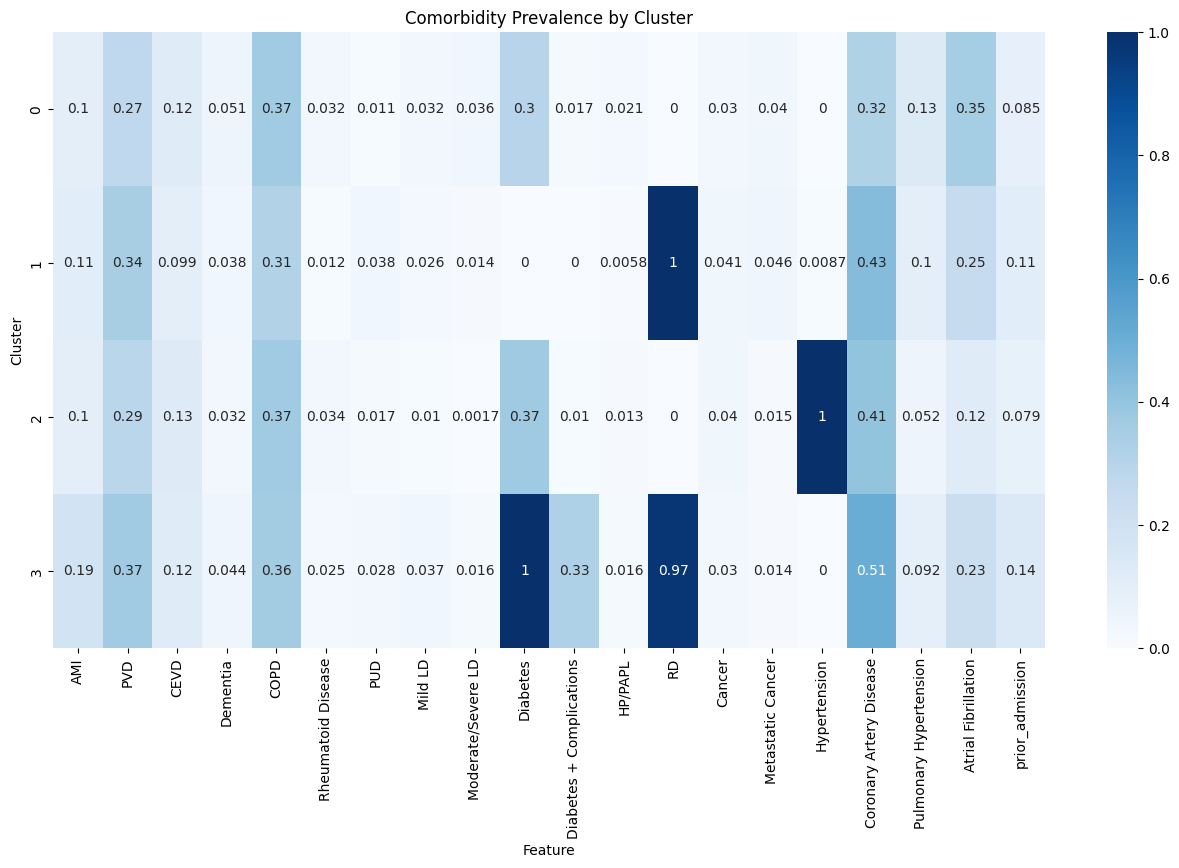

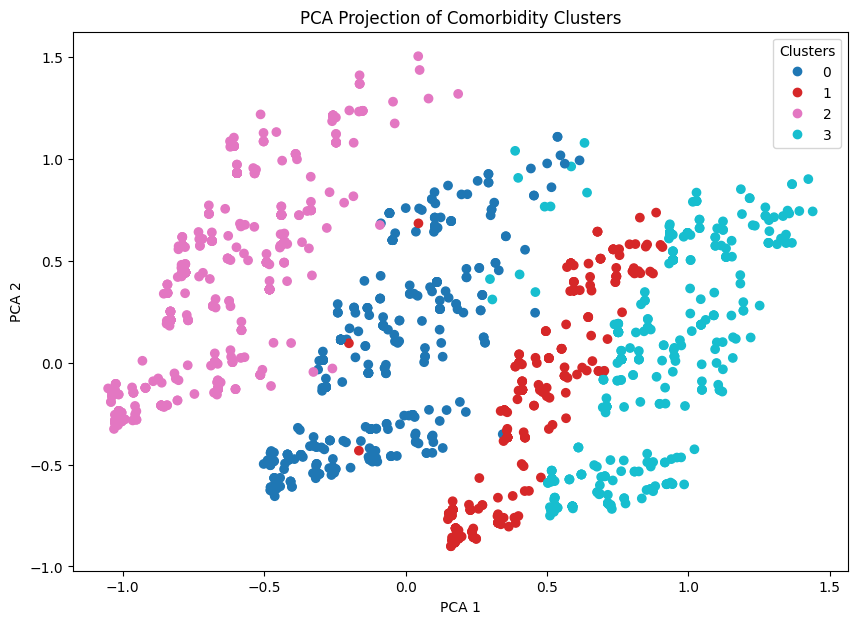


Most prevalent comorbidities per cluster:

Cluster 0 (470 patients):
  - COPD: 37.0%
  - Atrial Fibrillation: 35.3%
  - Coronary Artery Disease: 31.7%
  - Diabetes: 30.0%
  - PVD: 27.0%
  - Pulmonary Hypertension: 13.4%
  - CEVD: 12.1%
  - AMI: 10.0%

Cluster 1 (345 patients):
  - RD: 100.0%
  - Coronary Artery Disease: 43.5%
  - PVD: 34.5%
  - COPD: 31.3%
  - Atrial Fibrillation: 24.9%
  - AMI: 11.3%
  - prior_admission: 11.3%
  - Pulmonary Hypertension: 10.4%

Cluster 2 (596 patients):
  - Hypertension: 100.0%
  - Coronary Artery Disease: 40.6%
  - Diabetes: 37.4%
  - COPD: 36.9%
  - PVD: 28.5%
  - CEVD: 12.6%
  - Atrial Fibrillation: 12.1%
  - AMI: 10.2%

Cluster 3 (434 patients):
  - Diabetes: 100.0%
  - RD: 97.5%
  - Coronary Artery Disease: 50.7%
  - PVD: 37.1%
  - COPD: 35.9%
  - Diabetes + Complications: 32.7%
  - Atrial Fibrillation: 23.0%
  - AMI: 19.1%
  - prior_admission: 14.3%
  - CEVD: 12.0%


In [151]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

num_males = full[full["gender"] == 1.0]["subject_id"].nunique()
num_females = full[full["gender"] == 0.0]["subject_id"].nunique()

unique = full["subject_id"].nunique()
print(f"Total number of male patients: {num_males}")
print(f"Total number of female patients: {num_females}")
print(unique)
# Assume `full` dataframe is loaded with comorbidity flags and other features as in your preprocessing
# Identify the latest admission per patient
latest_adm = full.sort_values('admittime').groupby('subject_id').tail(1)

# Calculate admission counts per patient
adm_counts = full.groupby('subject_id')['hadm_id'].nunique()

# Add prior_admission flag: 1 if patient had previous admissions, else 0
latest_adm['prior_admission'] = latest_adm['subject_id'].map(lambda x: 1 if adm_counts[x] > 1 else 0)

# 1. Extract comorbidity columns
comorbidity_columns = [
    "AMI", "PVD", "CEVD", "Dementia", "COPD", "Rheumatoid Disease", "PUD",
    "Mild LD", "Moderate/Severe LD", "Diabetes", "Diabetes + Complications",
    "HP/PAPL", "RD", "Cancer", "Metastatic Cancer", "Hypertension",
    "Coronary Artery Disease", "Pulmonary Hypertension", "Atrial Fibrillation"
]

# Features for clustering (add prior_admission)
comorbidity_columns = comorbidity_columns + ['prior_admission']

# Prepare clustering data using latest admissions only
comorbidity_data = latest_adm[["subject_id", "hadm_id"] + comorbidity_columns].drop_duplicates(subset=["subject_id", "hadm_id"])
# Get unique patient-hadm_id combinations to cluster on comorbidities at admission level
#comorbidity_data = full[["subject_id", "hadm_id"] + comorbidity_columns].drop_duplicates(subset=["subject_id", "hadm_id"])

# 2. Clustering based on comorbidities
X_comorb = comorbidity_data[comorbidity_columns].values
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_comorb)

comorbidity_data['cluster'] = clusters
# Map (subject_id, hadm_id) → cluster
hadm_cluster_map = {
    (row.subject_id, row.hadm_id): row.cluster
    for row in comorbidity_data.itertuples(index=False)
}
# 3. Characterize clusters by comorbidity prevalence


cluster_summary = comorbidity_data.groupby('cluster')[comorbidity_columns].mean()

print("Comorbidity prevalence per cluster:")
print(cluster_summary)

# 4. Visualization: Heatmap of comorbidity prevalence per cluster
plt.figure(figsize=(16, 8))
sns.heatmap(cluster_summary, annot=True, cmap="Blues", cbar=True)
plt.title("Comorbidity Prevalence by Cluster")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.savefig(f"ComorbidityPrevalence_k={n_clusters}.png")
plt.show()

# 5. Optional: Use PCA to visualize patient distribution in 2D by clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_comorb)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("PCA Projection of Comorbidity Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig(f"PCAClusters_k={n_clusters}.png")
plt.show()

# 6. Print comorbidities per cluster (based on prevalence)

# Define threshold for considering a comorbidity "common" in a cluster
threshold = 0.1

print("\nMost prevalent comorbidities per cluster:")
for cluster_id, row in cluster_summary.iterrows():
    prevalent = row[row >= threshold].sort_values(ascending=False)
    cluster_size = len(comorbidity_data[comorbidity_data['cluster'] == cluster_id])
    print(f"\nCluster {cluster_id} ({cluster_size} patients):")
    if prevalent.empty:
        print("  No comorbidities above threshold.")
    else:
        for comorb, value in prevalent.items():
            print(f"  - {comorb}: {value:.1%}")


In [152]:
print(full.head())

             charttime     stay_id   BMI  Bicarbonate  Creatinine  \
0  2186-03-20 00:00:00  30001336.0  77.0         22.0         1.1   
1  2186-03-20 01:00:00  30001336.0  77.0         22.0         1.1   
2  2186-03-20 02:00:00  30001336.0  77.0         22.0         1.1   
3  2186-03-20 03:00:00  30001336.0  77.0         22.0         1.1   
4  2186-03-20 04:00:00  30001336.0  77.0         22.0         1.1   

   Diastolic BP  Heart Rate  Hemoglobin  NT-proBNP  Platelet Count  Sodium  \
0          52.0        70.5         8.9       13.9           163.0   131.0   
1          61.0        68.5         8.9       13.9           163.0   131.0   
2          55.0        57.0         8.9       13.9           163.0   131.0   
3          68.0        55.0         8.9       13.9           163.0   131.0   
4          59.0        63.0         8.9       13.9           163.0   131.0   

   SpO2  Systolic BP  Temperature  Troponin T  WBC Count  subject_id  \
0  96.0        110.0         98.5         1.

In [153]:
# Create a prior_admission flag for all admissions (1 if patient had previous admissions, else 0)
full['prior_admission'] = full['subject_id'].map(lambda x: 1 if adm_counts[x] > 1 else 0)


In [154]:
features = [
    "Heart Rate", "Systolic BP", "Diastolic BP", "SpO2", "Temperature", "BMI",
    "Bicarbonate", "Creatinine", "Hemoglobin", "Platelet Count",
    "WBC Count", "Sodium", "NT-proBNP", "Troponin T"
]

In [155]:
window_size = 24  # hours
segments = []

for stay_id, group in full.groupby("stay_id"):
    if len(group) >= window_size:
        segment = group.iloc[:window_size]
        segments.append(segment)

# This produces a list of time-series windows


In [156]:
X = []
y_30d = []
y_1y = []
comorbidity_columns = list(comorbidity_icd_map.keys())
for stay_id, group in full.groupby("stay_id"):
    if len(group) >= window_size:
        segment = group.iloc[:window_size]
        
        # Repeat gender_numeric over time dimension
        gender_array = np.repeat(segment['gender'].iloc[0], window_size).reshape(-1, 1)
        
        # Select features and comorbidities
        time_series_features = segment[features+comorbidity_columns].values
        
        # Concatenate gender column (static) to each time step
        combined_features = np.hstack([time_series_features, gender_array])
        
        X.append(combined_features)
        y_30d.append(segment["death_within_30_days"].iloc[0])
        y_1y.append(segment["death_within_1_year"].iloc[0])



In [157]:
print(features)
print(comorbidity_columns)

['Heart Rate', 'Systolic BP', 'Diastolic BP', 'SpO2', 'Temperature', 'BMI', 'Bicarbonate', 'Creatinine', 'Hemoglobin', 'Platelet Count', 'WBC Count', 'Sodium', 'NT-proBNP', 'Troponin T']
['AMI', 'PVD', 'CEVD', 'Dementia', 'COPD', 'Rheumatoid Disease', 'PUD', 'Mild LD', 'Moderate/Severe LD', 'Diabetes', 'Diabetes + Complications', 'HP/PAPL', 'RD', 'Cancer', 'Metastatic Cancer', 'Hypertension', 'Coronary Artery Disease', 'Pulmonary Hypertension', 'Atrial Fibrillation']


In [158]:
X = np.array(X)
y_30d = np.array(y_30d)
y_1y = np.array(y_1y)
print(X,y_30d,y_1y)


[[[ 70.5        110.          52.         ...   0.           0.
     1.        ]
  [ 68.5        116.          61.         ...   0.           0.
     1.        ]
  [ 57.         104.          55.         ...   0.           0.
     1.        ]
  ...
  [ 63.         107.          56.         ...   0.           0.
     1.        ]
  [ 62.         114.          56.         ...   0.           0.
     1.        ]
  [ 70.         112.          61.         ...   0.           0.
     1.        ]]

 [[ 71.2        115.          59.7        ...   0.           0.
     1.        ]
  [ 73.4        117.          60.4        ...   0.           0.
     1.        ]
  [ 75.6        119.          61.1        ...   0.           0.
     1.        ]
  ...
  [ 71.         116.          57.         ...   0.           0.
     1.        ]
  [ 70.         116.          57.         ...   0.           0.
     1.        ]
  [ 73.         125.          58.         ...   0.           0.
     1.        ]]

 [[ 79.8    

In [159]:
#comorbidities cohort no prior admission

In [160]:
print(comorbidity_data.columns)

Index(['subject_id', 'hadm_id', 'AMI', 'PVD', 'CEVD', 'Dementia', 'COPD',
       'Rheumatoid Disease', 'PUD', 'Mild LD', 'Moderate/Severe LD',
       'Diabetes', 'Diabetes + Complications', 'HP/PAPL', 'RD', 'Cancer',
       'Metastatic Cancer', 'Hypertension', 'Coronary Artery Disease',
       'Pulmonary Hypertension', 'Atrial Fibrillation', 'prior_admission',
       'cluster'],
      dtype='object')


In [161]:
import os
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

# Assume full, features, and hadm_cluster_map already defined

# Step 1: Create folder to store per-patient files
os.makedirs("patients_csv", exist_ok=True)

# Save per-patient CSV files
for subject_id, group in full.groupby("subject_id"):
    patient_file = f"patients_csv/patient_{subject_id}.csv"
    group.to_csv(patient_file, index=False)

print("Saved individual patient CSV files.")

# Step 2: Create folder structure for clusters
base_cluster_dir = "clusters_csv"
os.makedirs(base_cluster_dir, exist_ok=True)

for cid in range(n_clusters):
    os.makedirs(os.path.join(base_cluster_dir, f"cluster_{cid}"), exist_ok=True)

# Step 3: Move per-patient files into corresponding cluster folder based on latest admission

# Build subject → cluster map based on latest admission
subject_cluster_map = {}
for (subject_id, hadm_id), cluster_id in hadm_cluster_map.items():
    subject_cluster_map[subject_id] = cluster_id  # Assign based on latest hadm_id

# Step 4: Copy files into cluster folders
import shutil

for subject_id in full['subject_id'].unique():
    cluster_id = subject_cluster_map.get(subject_id, None)
    if cluster_id is not None:
        src_file = f"patients_csv/patient_{subject_id}.csv"
        dest_file = os.path.join(base_cluster_dir, f"cluster_{cluster_id}", f"patient_{subject_id}.csv")
        shutil.copy(src_file, dest_file)

print("Files have been organized into cluster folders.")


Saved individual patient CSV files.
Files have been organized into cluster folders.


In [183]:

from collections import defaultdict
# ========== Extract time series windows ==========
window_size = 24#168 hours = one week
segments = []

X = []
y_30d = []
y_1y = []
subject_hadm_ids = []
#prior_adm_map = latest_adm.set_index('subject_id')['prior_admission']
#full['prior_admission'] = full['subject_id'].map(prior_adm_map)

for (subject_id, hadm_id), group in full.groupby(["subject_id", "hadm_id"]):
    if len(group) >= window_size:
        segment = group.iloc[:window_size]
        gender_array = np.repeat(segment["gender"].iloc[0], window_size).reshape(-1, 1)
        time_series_features = segment[features].copy()#values
        #combined_features = np.hstack([time_series_features, gender_array])
        
        X.append(time_series_features)
        y_30d.append(segment["death_within_30_days"].iloc[0])
        y_1y.append(segment["death_within_1_year"].iloc[0])
        subject_hadm_ids.append((subject_id, hadm_id))

#X = np.array(X)
#y_30d = np.array(y_30d)
#y_1y = np.array(y_1y)

# ========== Split time series into clusters ==========
cluster_X = defaultdict(list)
cluster_y_30d = defaultdict(list)
cluster_y_1y = defaultdict(list)

for i, (sid, hid) in enumerate(subject_hadm_ids):
    cluster_id = hadm_cluster_map.get((sid, hid), None)
    if cluster_id is not None:
        cluster_X[cluster_id].append(X[i])
        cluster_y_30d[cluster_id].append(y_30d[i])
        cluster_y_1y[cluster_id].append(y_1y[i])


# for cid in range(n_clusters):
#     cluster_X[cid] = cluster_X[cid]
#     cluster_y_30d[cid] = np.array(cluster_y_30d[cid])
#     cluster_y_1y[cid] = np.array(cluster_y_1y[cid])
#     print(f"Cluster {cid}: {len(cluster_X[cid])} samples")


In [184]:
import os

save_dir = "cluster_csv"
os.makedirs(save_dir, exist_ok=True)

for cid in range(n_clusters):
    cluster_folder = os.path.join(save_dir, f"cluster_30d_{cid}")
    os.makedirs(cluster_folder, exist_ok=True)

    for i, (df, label) in enumerate(zip(cluster_X[cid], cluster_y_30d[cid])):
        df_copy = df.copy()  # df is already a DataFrame
        df_copy["label_30d"] = label
        df_copy.to_csv(os.path.join(cluster_folder, f"sample_{i}.csv"), index=False)

    print(f"Saved {len(cluster_X[cid])} samples to {cluster_folder}")


for cid in range(n_clusters):
    cluster_folder = os.path.join(save_dir, f"cluster_1y_{cid}")
    os.makedirs(cluster_folder, exist_ok=True)

    for i, df in enumerate(cluster_X[cid]):  # df is a DataFrame
        df_copy = df.copy()
        df_copy["label_1y"] = cluster_y_1y[cid][i]
        df_copy.to_csv(os.path.join(cluster_folder, f"sample_{i}.csv"), index=False)

    print(f"Saved {len(cluster_X[cid])} samples to {cluster_folder}")


Saved 422 samples to cluster_csv/cluster_30d_0
Saved 303 samples to cluster_csv/cluster_30d_1
Saved 544 samples to cluster_csv/cluster_30d_2
Saved 386 samples to cluster_csv/cluster_30d_3
Saved 422 samples to cluster_csv/cluster_1y_0
Saved 303 samples to cluster_csv/cluster_1y_1
Saved 544 samples to cluster_csv/cluster_1y_2
Saved 386 samples to cluster_csv/cluster_1y_3


In [185]:
import os
import pandas as pd

save_dir = "cluster_csv"
os.makedirs(save_dir, exist_ok=True)

for cid in range(n_clusters):
    cluster_folder = os.path.join(save_dir, f"cluster_{cid}")
    os.makedirs(cluster_folder, exist_ok=True)

    for i, x in enumerate(cluster_X[cid]):
        df = pd.DataFrame(x)
        df["label_30d"] = cluster_y_30d[cid][i]
        df["label_1y"] = cluster_y_1y[cid][i]
        df.to_csv(os.path.join(cluster_folder, f"sample_{i}.csv"), index=False)

    print(f"Saved {len(cluster_X[cid])} samples to {cluster_folder}")

Saved 422 samples to cluster_csv/cluster_0
Saved 303 samples to cluster_csv/cluster_1
Saved 544 samples to cluster_csv/cluster_2
Saved 386 samples to cluster_csv/cluster_3



===== Gender: Male =====


/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Comorbidity prevalence per cluster:
              AMI       PVD      CEVD  Dementia      COPD  Rheumatoid Disease  \
cluster                                                                         
0        0.160839  0.332168  0.115385  0.052448  0.367133            0.031469   
1        0.208861  0.550633  0.126582  0.050633  0.335443            0.006329   
2        0.116883  0.346320  0.099567  0.021645  0.354978            0.012987   
3        0.073298  0.178010  0.094241  0.031414  0.340314            0.005236   

              PUD   Mild LD  Moderate/Severe LD  Diabetes  \
cluster                                                     
0        0.027972  0.038462            0.013986  1.000000   
1        0.012658  0.044304            0.031646  0.012658   
2        0.021645  0.017316            0.004329  0.419913   
3        0.036649  0.026178            0.057592  0.000000   

         Diabetes + Complications   HP/PAPL        RD    Cancer  \
cluster                                    

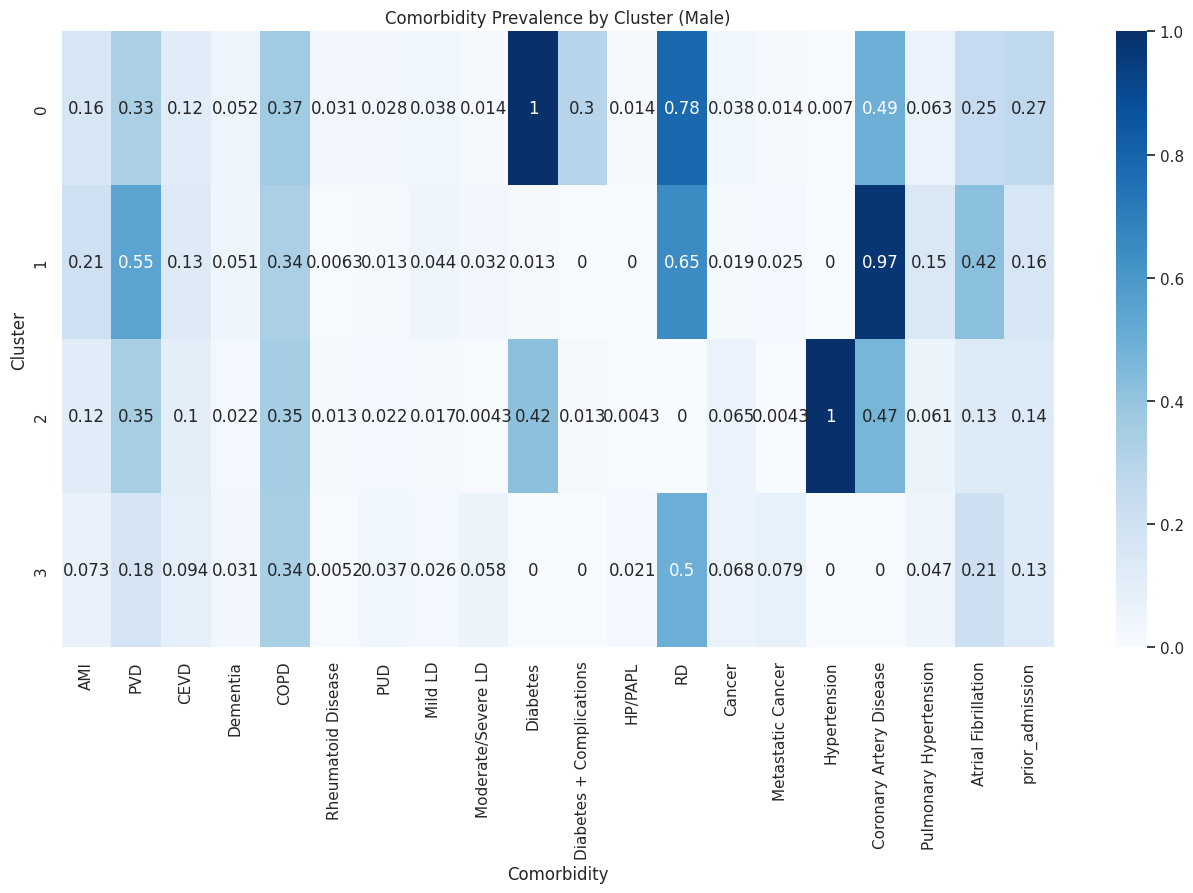

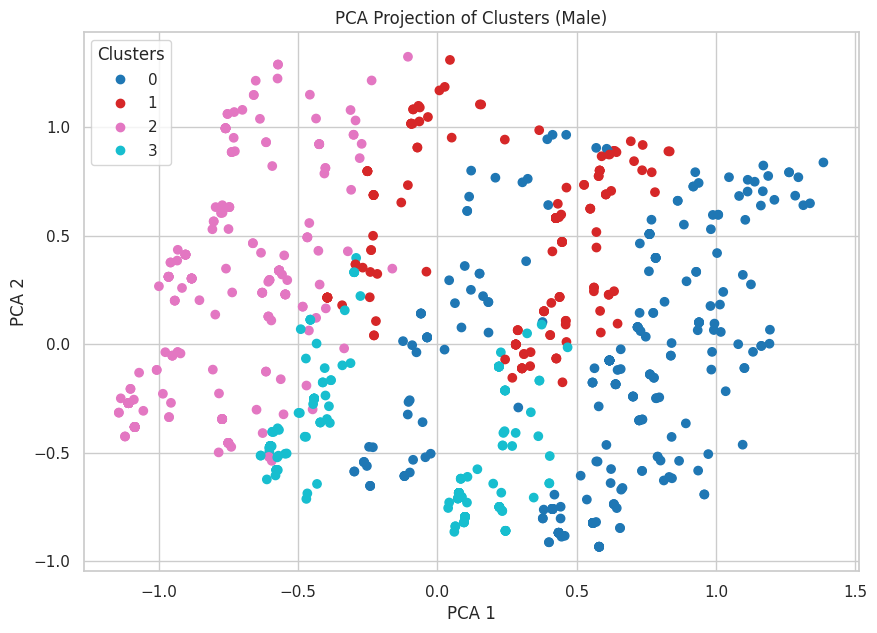


Most prevalent comorbidities per cluster:

Cluster 0 (286 patients):
  - Diabetes: 100.0%
  - RD: 78.3%
  - Coronary Artery Disease: 49.3%
  - COPD: 36.7%
  - PVD: 33.2%
  - Diabetes + Complications: 30.1%

Cluster 1 (158 patients):
  - Coronary Artery Disease: 97.5%
  - RD: 64.6%
  - PVD: 55.1%
  - Atrial Fibrillation: 42.4%
  - COPD: 33.5%

Cluster 2 (231 patients):
  - Hypertension: 100.0%
  - Coronary Artery Disease: 47.2%
  - Diabetes: 42.0%
  - COPD: 35.5%
  - PVD: 34.6%

Cluster 3 (191 patients):
  - RD: 49.7%
  - COPD: 34.0%

===== Gender: Female =====


/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Comorbidity prevalence per cluster:
              AMI       PVD      CEVD  Dementia      COPD  Rheumatoid Disease  \
cluster                                                                         
0        0.124528  0.294340  0.120755  0.015094  0.460377            0.015094   
1        0.087065  0.256219  0.097015  0.052239  0.320896            0.037313   
2        0.142857  0.341463  0.132404  0.027875  0.355401            0.024390   
3        0.068259  0.235495  0.150171  0.044369  0.334471            0.058020   

              PUD   Mild LD  Moderate/Severe LD  Diabetes  \
cluster                                                     
0        0.015094  0.015094            0.011321       1.0   
1        0.024876  0.019900            0.012438       0.0   
2        0.020906  0.027875            0.013937       1.0   
3        0.020478  0.006826            0.000000       0.0   

         Diabetes + Complications   HP/PAPL        RD    Cancer  \
cluster                                    

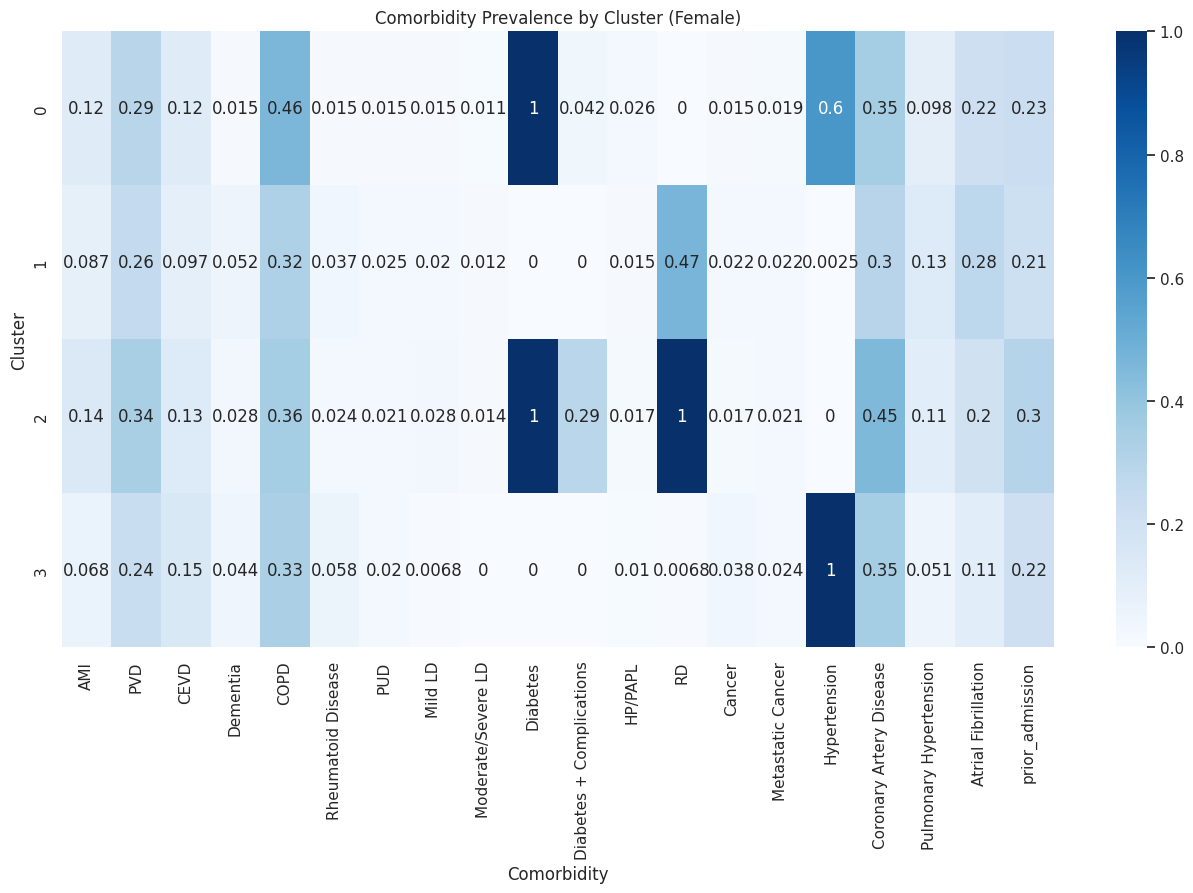

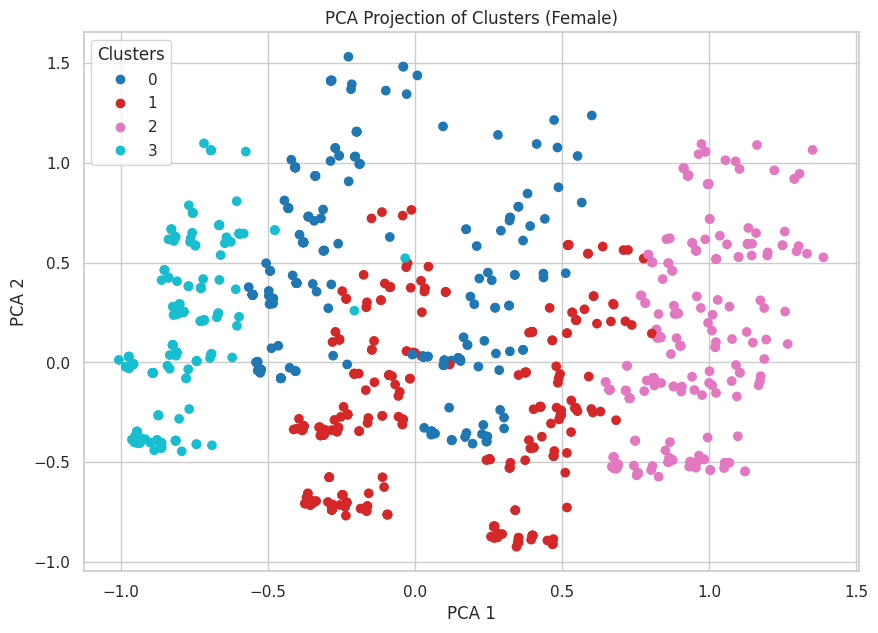


Most prevalent comorbidities per cluster:

Cluster 0 (265 patients):
  - Diabetes: 100.0%
  - Hypertension: 60.4%
  - COPD: 46.0%
  - Coronary Artery Disease: 35.5%

Cluster 1 (402 patients):
  - RD: 46.8%
  - COPD: 32.1%

Cluster 2 (287 patients):
  - Diabetes: 100.0%
  - RD: 100.0%
  - Coronary Artery Disease: 45.3%
  - COPD: 35.5%
  - PVD: 34.1%
  - prior_admission: 30.3%

Cluster 3 (293 patients):
  - Hypertension: 100.0%
  - Coronary Artery Disease: 35.5%
  - COPD: 33.4%


In [139]:
# Set visual styles
sns.set(style="whitegrid")

# Assumed already loaded: `full` dataframe with comorbidities + gender
comorbidity_columns = [
    "AMI", "PVD", "CEVD", "Dementia", "COPD", "Rheumatoid Disease", "PUD",
    "Mild LD", "Moderate/Severe LD", "Diabetes", "Diabetes + Complications",
    "HP/PAPL", "RD", "Cancer", "Metastatic Cancer", "Hypertension",
    "Coronary Artery Disease", "Pulmonary Hypertension", "Atrial Fibrillation", "prior_admission"
]

# Threshold for a comorbidity to be considered prevalent in a cluster
threshold = 0.3
n_clusters = 4

# Loop over genders
for gender in [1, 0]:
    gender_label = "Male" if gender == 1 else "Female"
    print(f"\n===== Gender: {gender_label} =====")

    # Filter gender-specific data
    gender_data = full[full["gender"] == gender]

    comorb_data = gender_data[["subject_id", "hadm_id"] + comorbidity_columns].drop_duplicates(subset=["subject_id", "hadm_id"])

    # Check for empty data
    if comorb_data.empty:
        print(f"Skipping {gender_label} cohort (no data available).")
        continue

    X_comorb = comorb_data[comorbidity_columns].values

    # Check if enough samples for clustering
    if len(X_comorb) < n_clusters:
        print(f"Skipping {gender_label} cohort (only {len(X_comorb)} samples, need at least {n_clusters}).")
        continue

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_comorb)
    comorb_data = comorb_data.copy()
    comorb_data['cluster'] = clusters

    # Summary table
    cluster_summary = comorb_data.groupby('cluster')[comorbidity_columns].mean()
    print("Comorbidity prevalence per cluster:")
    print(cluster_summary)

    # Heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(cluster_summary, annot=True, cmap="Blues", cbar=True)
    plt.title(f"Comorbidity Prevalence by Cluster ({gender_label})")
    plt.ylabel("Cluster")
    plt.xlabel("Comorbidity")
    plt.savefig(f"ComorbidityPrevalence{gender_label}.png")
    plt.show()

    # PCA visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_comorb)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title(f"PCA Projection of Clusters ({gender_label})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.savefig(f"PCAClusters{gender_label}.png")
    plt.show()


    # Prevalent comorbidities per cluster
    print("\nMost prevalent comorbidities per cluster:")
    for cluster_id, row in cluster_summary.iterrows():
        prevalent = row[row >= threshold].sort_values(ascending=False)
        cluster_size = len(comorb_data[comorb_data['cluster'] == cluster_id])
        print(f"\nCluster {cluster_id} ({cluster_size} patients):")
        if prevalent.empty:
            print("  No comorbidities above threshold.")
        else:
            for comorb, value in prevalent.items():
                print(f"  - {comorb}: {value:.1%}")


In [142]:
import pandas as pd
import numpy as np

# Map subject_id to gender from full dataframe
subject_gender_map = full.drop_duplicates("subject_id").set_index("subject_id")["gender"].to_dict()

# Separate data based on gender
X_male, y_30d_male, y_1y_male = [], [], []
X_female, y_30d_female, y_1y_female = [], [], []

for i, (sid, _) in enumerate(subject_hadm_ids):
    gender = subject_gender_map.get(sid)
    if gender == 1:  # Male
        X_male.append(X[i])
        y_30d_male.append(y_30d[i])
        y_1y_male.append(y_1y[i])
    elif gender == 0:  # Female
        X_female.append(X[i])
        y_30d_female.append(y_30d[i])
        y_1y_female.append(y_1y[i])

# Convert to numpy arrays
X_male = np.array(X_male)
X_female = np.array(X_female)

# Flatten and append labels
flat_male = np.array([x.flatten().tolist() + [y30, y1y] for x, y30, y1y in zip(X_male, y_30d_male, y_1y_male)])
flat_female = np.array([x.flatten().tolist() + [y30, y1y] for x, y30, y1y in zip(X_female, y_30d_female, y_1y_female)])

# Define column names
num_time_steps, num_features = X_male.shape[1], X_male.shape[2]
columns = [f"t{t}_{f}" for t in range(num_time_steps) for f in range(num_features)] + ["death_30d", "death_1y"]

# Create DataFrames and save
pd.DataFrame(flat_male, columns=columns).to_csv("flattened_time_series_male.csv", index=False)
pd.DataFrame(flat_female, columns=columns).to_csv("flattened_time_series_female.csv", index=False)

print(f"Saved {X_male.shape[0]} male and {X_female.shape[0]} female samples as flattened CSVs.")


Saved 781 male and 1110 female samples as flattened CSVs.


In [ ]:
flattened_data = []

for i, ts in enumerate(X):
    row = {
        "subject_id": subject_hadm_ids[i][0],
        "hadm_id": subject_hadm_ids[i][1],
        "death_within_30_days": y_30d[i],
        "death_within_1_year": y_1y[i],
    }
    for t in range(ts.shape[0]):
        for f in range(ts.shape[1]):
            row[f"t{t}_f{f}"] = ts[t, f]
    flattened_data.append(row)

# Convert to DataFrame and save
df_ts = pd.DataFrame(flattened_data)
df_ts.to_csv("flattened_time_series.csv", index=False)


In [141]:

num_males = full[full["gender"] == 1]["subject_id"].nunique()
num_females = full[full["gender"] == 0]["subject_id"].nunique()


print(f"Total number of male patients: {num_males}")
print(f"Total number of female patients: {num_females}")

Total number of male patients: 773
Total number of female patients: 1072


In [97]:
total_patients = full["subject_id"].nunique()
total_admissions = full[["subject_id", "hadm_id"]].drop_duplicates().shape[0]

print(f"Total unique patients: {total_patients}")
print(f"Total unique admissions (subject_id, hadm_id pairs): {total_admissions}")


Total unique patients: 1845
Total unique admissions (subject_id, hadm_id pairs): 2113


In [98]:
# Group by subject_id to get one row per patient
death_per_patient = full.groupby("subject_id")[[
    "death_within_30_days", "death_within_1_year"
]].max()  # Or use `.any()` to convert to boolean

# Print unique patient-level label distribution
print("\nLabel distribution per unique patient (0 = alive, 1 = dead):")
print("death_within_30_days:\n", death_per_patient["death_within_30_days"].value_counts(dropna=False))
print("death_within_1_year:\n", death_per_patient["death_within_1_year"].value_counts(dropna=False))



Label distribution per unique patient (0 = alive, 1 = dead):
death_within_30_days:
 death_within_30_days
False    1709
True      136
Name: count, dtype: int64
death_within_1_year:
 death_within_1_year
False    1695
True      150
Name: count, dtype: int64


In [ ]:
#with prior admission

Total number of male patients: 773
Total number of female patients: 1072


/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Comorbidity prevalence + prior admission by cluster:
              AMI       PVD      CEVD  Dementia      COPD  Rheumatoid Disease  \
cluster                                                                         
0        0.100000  0.270213  0.121277  0.051064  0.370213            0.031915   
1        0.113043  0.344928  0.098551  0.037681  0.313043            0.011594   
2        0.102349  0.285235  0.125839  0.031879  0.369128            0.033557   
3        0.191244  0.370968  0.119816  0.043779  0.359447            0.025346   

              PUD   Mild LD  Moderate/Severe LD  Diabetes  \
cluster                                                     
0        0.010638  0.031915            0.036170  0.300000   
1        0.037681  0.026087            0.014493  0.000000   
2        0.016779  0.010067            0.001678  0.374161   
3        0.027650  0.036866            0.016129  1.000000   

         Diabetes + Complications   HP/PAPL        RD    Cancer  \
cluster                   

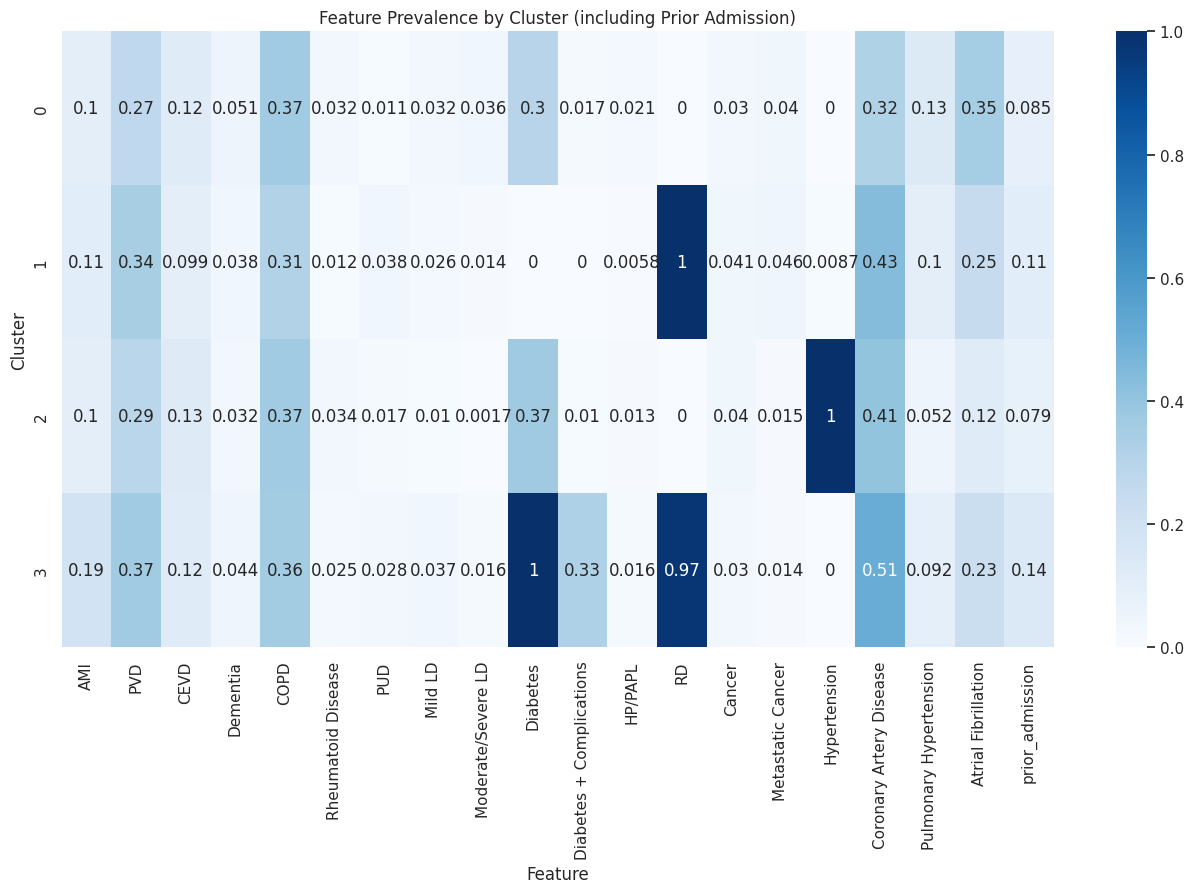

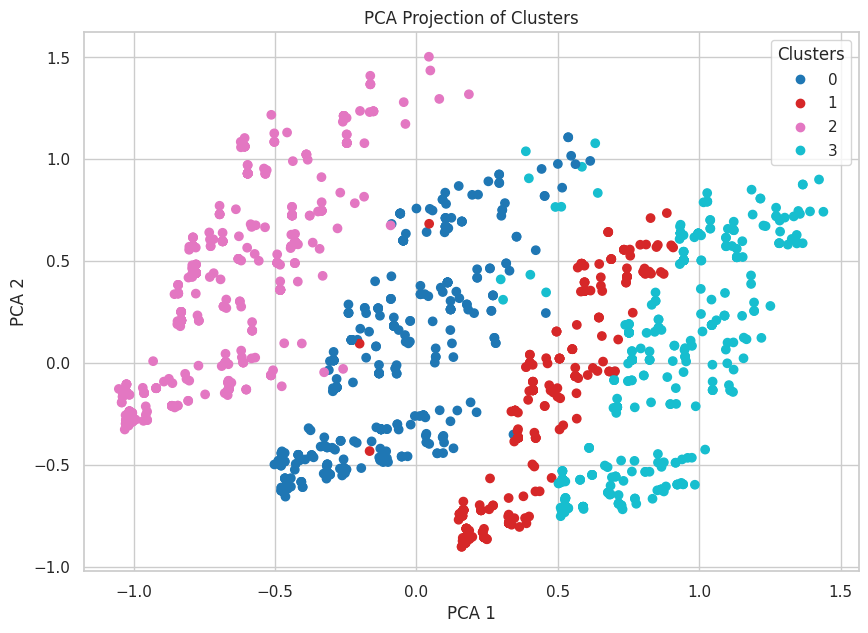


Most prevalent features per cluster (threshold >= 10%):

Cluster 0 (470 patients):
  - COPD: 37.0%
  - Atrial Fibrillation: 35.3%
  - Coronary Artery Disease: 31.7%
  - Diabetes: 30.0%
  - PVD: 27.0%
  - Pulmonary Hypertension: 13.4%
  - CEVD: 12.1%
  - AMI: 10.0%

Cluster 1 (345 patients):
  - RD: 100.0%
  - Coronary Artery Disease: 43.5%
  - PVD: 34.5%
  - COPD: 31.3%
  - Atrial Fibrillation: 24.9%
  - AMI: 11.3%
  - prior_admission: 11.3%
  - Pulmonary Hypertension: 10.4%

Cluster 2 (596 patients):
  - Hypertension: 100.0%
  - Coronary Artery Disease: 40.6%
  - Diabetes: 37.4%
  - COPD: 36.9%
  - PVD: 28.5%
  - CEVD: 12.6%
  - Atrial Fibrillation: 12.1%
  - AMI: 10.2%

Cluster 3 (434 patients):
  - Diabetes: 100.0%
  - RD: 97.5%
  - Coronary Artery Disease: 50.7%
  - PVD: 37.1%
  - COPD: 35.9%
  - Diabetes + Complications: 32.7%
  - Atrial Fibrillation: 23.0%
  - AMI: 19.1%
  - prior_admission: 14.3%
  - CEVD: 12.0%


In [120]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Count males and females (unique patients)
num_males = full[full["gender"] == 1]["subject_id"].nunique()
num_females = full[full["gender"] == 0]["subject_id"].nunique()

print(f"Total number of male patients: {num_males}")
print(f"Total number of female patients: {num_females}")


# Identify the latest admission per patient
latest_adm = full.sort_values('admittime').groupby('subject_id').tail(1)

# Calculate admission counts per patient
adm_counts = full.groupby('subject_id')['hadm_id'].nunique()

# Add prior_admission flag: 1 if patient had previous admissions, else 0
latest_adm['prior_admission'] = latest_adm['subject_id'].map(lambda x: 1 if adm_counts[x] > 1 else 0)

# Define comorbidity columns
comorbidity_columns = [
    "AMI", "PVD", "CEVD", "Dementia", "COPD", "Rheumatoid Disease", "PUD",
    "Mild LD", "Moderate/Severe LD", "Diabetes", "Diabetes + Complications",
    "HP/PAPL", "RD", "Cancer", "Metastatic Cancer", "Hypertension",
    "Coronary Artery Disease", "Pulmonary Hypertension", "Atrial Fibrillation"
]

# Features for clustering (add prior_admission)
features = comorbidity_columns + ['prior_admission']

# Prepare clustering data using latest admissions only
comorbidity_data = latest_adm[["subject_id", "hadm_id"] + features].drop_duplicates(subset=["subject_id", "hadm_id"])

# 2. Clustering based on comorbidities + prior admission
X_comorb = comorbidity_data[features].values

# Choose number of clusters
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_comorb)

comorbidity_data['cluster'] = clusters

# 3. Characterize clusters by feature prevalence
cluster_summary = comorbidity_data.groupby('cluster')[features].mean()

print("Comorbidity prevalence + prior admission by cluster:")
print(cluster_summary)

# 4. Visualization: Heatmap of feature prevalence per cluster
plt.figure(figsize=(16, 8))
sns.heatmap(cluster_summary, annot=True, cmap="Blues", cbar=True)
plt.title("Feature Prevalence by Cluster (including Prior Admission)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.savefig(f"FeaturePrevalence_k={n_clusters}.png")
plt.show()

# 5. PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_comorb)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("PCA Projection of Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig(f"PCAClusters_k={n_clusters}.png")
plt.show()

# 6. Print prevalent features per cluster
threshold = 0.1

print("\nMost prevalent features per cluster (threshold >= 10%):")
for cluster_id, row in cluster_summary.iterrows():
    prevalent = row[row >= threshold].sort_values(ascending=False)
    cluster_size = len(comorbidity_data[comorbidity_data['cluster'] == cluster_id])
    print(f"\nCluster {cluster_id} ({cluster_size} patients):")
    if prevalent.empty:
        print("  No features above threshold.")
    else:
        for feat, val in prevalent.items():
            print(f"  - {feat}: {val:.1%}")


In [112]:
# List of comorbidity columns
comorbidity_columns = [
    "AMI", "PVD", "CEVD", "Dementia", "COPD", "Rheumatoid Disease", "PUD",
    "Mild LD", "Moderate/Severe LD", "Diabetes", "Diabetes + Complications",
    "HP/PAPL", "RD", "Cancer", "Metastatic Cancer", "Hypertension",
    "Coronary Artery Disease", "Pulmonary Hypertension", "Atrial Fibrillation", "prior_admission"
]

# Identify rows (admissions) where all comorbidity flags are 0
no_comorbidity_rows = comorbidity_data[comorbidity_columns].sum(axis=1) == 0

# Patients with at least one admission without any comorbidity
patients_no_comorb_any_admission = comorbidity_data.loc[no_comorbidity_rows, "subject_id"].unique()

print(f"Number of patients with at least one admission with no comorbidities: {len(patients_no_comorb_any_admission)}")
print("Example patient IDs:", no_comorbidity_rows[:10])


Number of patients with at least one admission with no comorbidities: 45
Example patient IDs: 182957    False
28666     False
121742    False
132962    False
100438    False
67225     False
13392     False
95517     False
72202     False
28127     False
dtype: bool


In [113]:
# For each patient, check if sum of all their comorbidity flags is zero across all admissions
patient_comorbidity_sum = comorbidity_data.groupby('subject_id')[comorbidity_columns].sum()

# Patients who have zero for all comorbidities (never had any)
patients_no_comorb_any_admission = patient_comorbidity_sum[(patient_comorbidity_sum.sum(axis=1) == 0)].index

print(f"Number of patients who never had any comorbidity: {len(patients_no_comorb_any_admission)}")
print("Example patient IDs:", list(patients_no_comorb_any_admission[:10]))


Number of patients who never had any comorbidity: 45
Example patient IDs: [10391526, 10841633, 10958454, 10981637, 11249665, 11418556, 11438886, 11863318, 12330014, 12341414]


In [114]:
# Group by patient and check if they ever had each comorbidity (any=1)
comorbidity_any_per_patient = comorbidity_data.groupby("subject_id")[comorbidity_columns].max()

# Count number of patients per comorbidity
comorbidity_patient_counts = comorbidity_any_per_patient.sum().sort_values(ascending=False)

print("\nNumber of unique patients with each comorbidity:")
pd.set_option('display.max_rows', 20)
print(comorbidity_patient_counts)



Number of unique patients with each comorbidity:
Diabetes                    798
RD                          768
Coronary Artery Disease     761
COPD                        658
Hypertension                599
PVD                         577
Atrial Fibrillation         424
AMI                         230
CEVD                        218
prior_admission             188
Pulmonary Hypertension      170
Diabetes + Complications    156
Dementia                     75
Cancer                       65
Metastatic Cancer            50
Rheumatoid Disease           50
Mild LD                      46
PUD                          40
Moderate/Severe LD           30
HP/PAPL                      27
dtype: int64


In [115]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

def load_csv_sample_multi(file_path, label_cols):
    file_path = file_path.decode()  # decode the file path

    # Decode bytes to str if passed from tf.numpy_function
    label_cols = [col.decode() if isinstance(col, bytes) else col for col in label_cols]

    df = pd.read_csv(file_path)
    labels = df[label_cols].iloc[0].values.astype(np.float32)
    X = df.drop(columns=label_cols).values.astype(np.float32)
    return X, labels


def tf_timeseries_dataset_from_directory(root_dir, label_cols, clusters=None):
    all_files = []

    cluster_dirs = [f"cluster_{clusters}"] if isinstance(clusters, int) else \
                   [f"cluster_{c}" for c in clusters] if clusters else \
                   [d for d in os.listdir(root_dir) if d.startswith("cluster_")]

    for cluster in cluster_dirs:
        cluster_path = os.path.join(root_dir, cluster)
        files = [os.path.join(cluster_path, f) for f in os.listdir(cluster_path) if f.endswith(".csv")]
        all_files.extend(files)

    file_ds = tf.data.Dataset.from_tensor_slices(all_files)

    def load_py_func(file_path):
        return tf.numpy_function(
            func=load_csv_sample_multi,
            inp=[file_path, label_cols],
            Tout=(tf.float32, tf.float32)
        )

    return file_ds.map(load_py_func)


In [116]:
ds = tf_timeseries_dataset_from_directory(
    "cluster_csv",
    label_cols=["label_30d", "label_1y"],
    clusters=[0, 1, 2, 3]
)

ds = ds.batch(32)

for batch_x, batch_y in ds.take(1):
    print(batch_x)  # (32, 24, num_features)
    print(batch_y)  # (32, 3)  <-- 3 labels per sample


2025-07-05 17:05:42.202655: W tensorflow/core/framework/op_kernel.cc:1829] UNKNOWN: KeyError: "['label_2y'] not in index"
Traceback (most recent call last):

  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_166053/3734971808.py", line 13, in load_csv_sample_multi
    labels = df[label_cols].iloc[0].values.astype(np.float32)
             ~~^^^^^^^^^^^^

  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/pandas/core/frame.py", line 3899, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packag

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyError: "['label_2y'] not in index"
Traceback (most recent call last):

  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_166053/3734971808.py", line 13, in load_csv_sample_multi
    labels = df[label_cols].iloc[0].values.astype(np.float32)
             ~~^^^^^^^^^^^^

  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/pandas/core/frame.py", line 3899, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 6114, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)

  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 6178, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")

KeyError: "['label_2y'] not in index"


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 